**Title**

## (1) Introduction:
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and fully describe the dataset that was used to answer the question


## (2) Methods:
- describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.

## (3) Code and Results:

- loads data 
- wrangles and cleans the data to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
- note: all figures should have a figure number and a legend


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


          Truth
Prediction No Yes
       No   0   0
       Yes 13  36

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


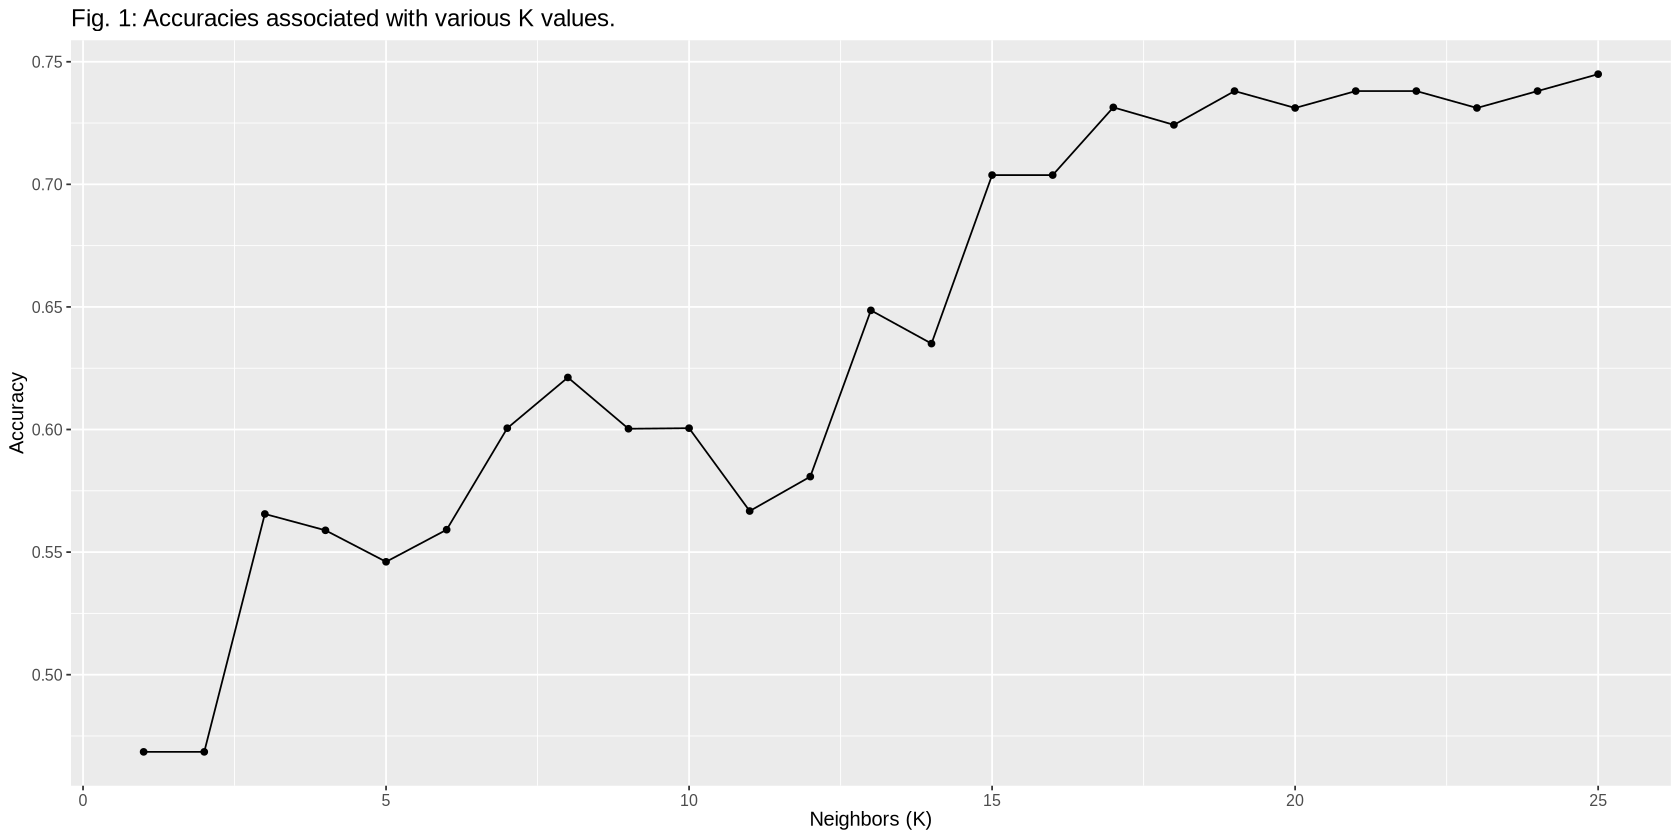

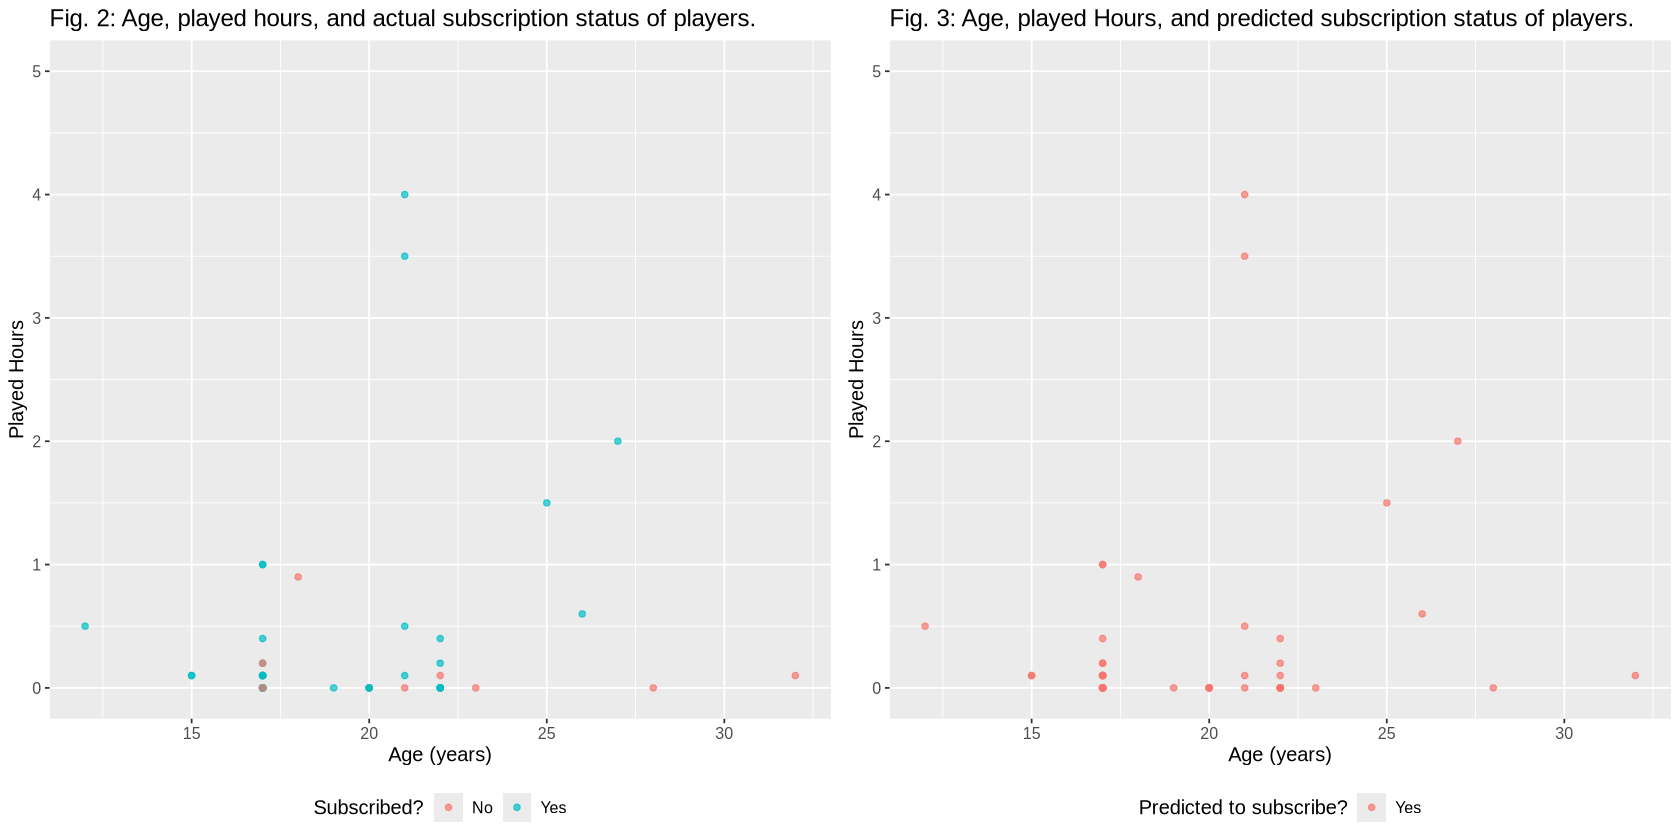

In [35]:

# -------------------------



players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_best_spec) |>
    fit(data = players_train)

players_predicted <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test) 

players_predicted_accuracy <- players_predicted |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    slice_max(.estimate) |>
    pull(.estimate)

players_predicted_conf <- players_predicted |>
    conf_mat(truth = subscribe, estimate = .pred_class)


players_plot <- players_predicted |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.7) +
    labs(x = "Age (years)", y = "Played Hours", title = "Fig. 2: Age, played hours, and actual subscription status of players.", color = "Subscribed?") +
    ylim(0, 5) +
    theme(text = element_text(size = 12), legend.position = "bottom", legend.direction = "horizontal")

players_predicted_plot <- players_predicted |>
    ggplot(aes(x = Age, y = played_hours, color = .pred_class)) +
    geom_point(alpha = 0.7) +
    labs(x = "Age (years)", y = "Played Hours", title = "Fig. 3: Age, played Hours, and predicted subscription status of players.", color = "Predicted to subscribe?") +
    ylim(0, 5) +
    theme(text = element_text(size = 12), legend.position = "bottom", legend.direction = "horizontal")


k_accuracies_plot
players_predicted_conf
plot_grid(players_plot, players_predicted_plot, ncol = 2)


#for billy: is it ok that i condensed this all?

mention why there is third color (opacity)

analyze accuracy, precision, and recall ––what it implies
talk about class balance.

why lim at ylim

tends to predict subscribed because of class imbalance. - high recall, so minimizes false positives.

## (4) Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?